<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Multiple Linear Regression


Estimated time needed: **15** minutes
    

## Objectives

After completing this lab, you will be able to:

* Use scikit-learn to implement multiple linear regression
* Create, train, and test a multiple linear regression model on real data


### Import needed packages


For this lab, you will need to have the following packages:
 - NumPy
 - Matplotlib
 - Pandas
 - Scikit-learn

To avoid issues importing these libraries, you may execute the following cell to ensure they are available.


In [ ]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3

Now, you can import these libraries for making the code.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load the data
The dataset you will use resides at the following URL. You can use the URL directly with the Pandas library to load the dataset.


In [2]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"


## Understand the data

### `FuelConsumption.csv`:
You will download and use a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODEL YEAR** e.g. 2014
- **MAKE** e.g. VOLVO
- **MODEL** e.g. S60 AWD
- **VEHICLE CLASS** e.g. COMPACT
- **ENGINE SIZE** e.g. 3.0
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. AS6
- **FUEL TYPE** e.g. Z
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 13.2
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 9.5
- **FUEL CONSUMPTION COMBINED (L/100 km)** e.g. 11.5
- **FUEL CONSUMPTION COMBINED MPG (MPG)** e.g. 25
- **CO2 EMISSIONS (g/km)** e.g. 182 

Your task will be to create a multiple linear regression model using some of these features to predict CO2 emissions of unobserved cars based on the selected features. 


<h2 id="reading_data">Load the data</h2>


In [3]:
df = pd.read_csv(url)

# verify successful load with some randomly selected records
df.sample(5)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
470,2014,GMC,YUKON,SUV - STANDARD,5.3,8,A6,E,21.5,14.6,18.4,15,294
682,2014,LINCOLN,MKX AWD,SUV - SMALL,3.7,6,AS6,X,13.7,10.4,12.2,23,281
889,2014,PORSCHE,BOXSTER S,TWO-SEATER,3.4,6,M6,Z,11.9,8.6,10.4,27,239
111,2014,BMW,750Li xDRIVE,FULL-SIZE,4.4,8,A8,Z,15.0,9.8,12.7,22,292
127,2014,BMW,X1 xDRIVE35i,SUV - SMALL,3.0,6,A6,Z,13.2,8.9,11.3,25,260


### Explore and select features


Let's select a few features to work with that might be predictive of CO2 emissions. 


In [ ]:
df.describe()

Notice that some of the variables are not included in the description. This is because they aren't numerical. In practice, you would analyze these features if required to improve the accuracy of your model. In the interest of time, you can omit this step here.  
Notice also that MODELYEAR is the same for all cars, so you can drop these variables for this modeling illustration.


In [4]:
# Drop categoricals and any unseless columns
df = df.drop(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE',],axis=1)

Now that you have eliminated some features, take a look at the relationships among the remaining features. 

Analyzing a correlation matrix that displays the pairwise correlations between all features indicates the level of independence between them. 

It also indicates how predictive each feature is of the target. 

You want to eliminate any strong dependencies or correlations between features by selecting the best one from each correlated group.


In [ ]:
df.corr()

Look at the bottom row, which shows the correlation between each variable and the target, 'CO2EMISSIONS'. Each of these shows a fairly high level of correlation, each exceeding 85% in magnitude. Thus all of these features are good candidates. 

Next, examine the correlations of the distinct pairs. 'ENGINESIZE' and 'CYLINDERS' are highly correlated, but 'ENGINESIZE' is more correlated with the target, so we can drop 'CYLINDERS'. 

Similarly, each of the four fuel economy variables is highly correlated with each other. Since FUELCONSUMPTION_COMB_MPG is the most correlated with the target, you can drop the others: 'FUELCONSUMPTION_CITY,' 'FUELCONSUMPTION_HWY,' 'FUELCONSUMPTION_COMB.' 

Notice that FUELCONSUMPTION_COMB and FUELCONSUMPTION_COMB_MPG are not perfectly correlated. They should be, though, because they measure the same property in different units. In practice, you would investigate why this is the case. You might find out that some or all of the data is not useable as is.


In [5]:
df = df.drop(['CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB',],axis=1)

In [6]:
df.head(9)

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244
5,3.5,28,230
6,3.5,28,232
7,3.7,25,255
8,3.7,24,267


To help with selecting predictive features that are not redundant, consider the following scatter matrix, which shows the scatter plots for each pair of input features. The diagonal of the matrix shows each feature's histogram.


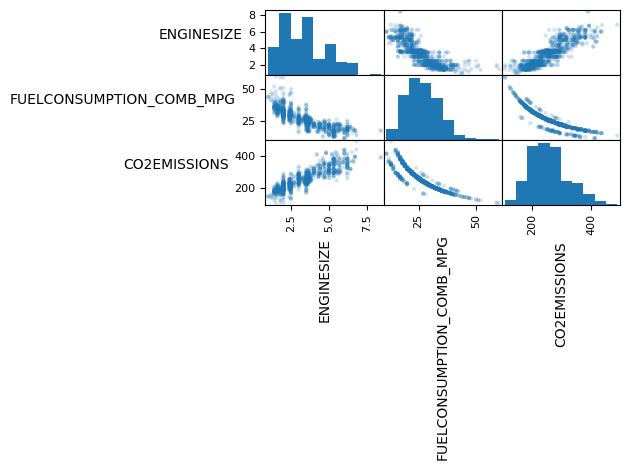

In [7]:
axes = pd.plotting.scatter_matrix(df, alpha=0.2)
# need to rotate axis labels so we can read them
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()
    

As you can see, the relationship between 'FUELCONSUMPTION_COMB_MPG' and 'CO2EMISSIONS' is non-linear. In addition, you can clearly see three different curves. This suggests exploring the categorical variables to see if they are able to explain these differences. Let's leave this as an exercise for you to explore deeper. Regarding the non-linearity, you will handle this in the next lab. For now, let's just consider through modeling whether fuel economy explains some of the variances in the target as is.


### Extract the input features and labels from the data set
Extract the required columns and convert the resulting dataframes to NumPy arrays.


In [8]:
X = df.iloc[:,[0,1]].to_numpy()
y = df.iloc[:,[2]].to_numpy()

### Preprocess selected features


You should standardize your input features so the model doesn't inadvertently favor any feature due to its magnitude.
The typical way to do this is to subtract the mean and divide by the standard deviation. Scikit-learn can do this for you.


In [9]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

In practice, if you want to properly evaluate your model, you should definitely not apply such operations to the entire dataset but to the train and test data separately. There's more to it than that. You'll dive deeper into this and other advanced evaluation pitfalls later in the course.


In [10]:
pd.DataFrame(X_std).describe().round(2)

,0,1
count,1067.00,1067.00
mean,0.00,-0.00
std,1.00,1.00
min,-1.66,-2.07
25%,-0.95,-0.73
50%,0.04,-0.06
75%,0.67,0.61
max,3.57,4.50


As you can see, a standardized variable has zero mean and a standard deviation of one.


### Create train and test datasets
Randomly split your data into train and test sets, using 80% of the dataset for training and reserving the remaining 20% for testing.


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.2,random_state=42)

### Build a multiple linear regression model
Multiple and simple linear regression models can be implemented with exactly the same scikit-learn tools.


In [12]:
from sklearn import linear_model

# create a model object
regressor = linear_model.LinearRegression()

# train the model in the training data
regressor.fit(X_train, y_train)

# Print the coefficients
coef_ =  regressor.coef_
intercept_ = regressor.intercept_

print ('Coefficients: ',coef_)
print ('Intercept: ',intercept_)


Coefficients:  [[ 25.27339614 -37.4381472 ]]
Intercept:  [256.29072488]


The Coefficients and Intercept parameters define the best-fit hyperplane to the data. Since there are only two variables, hence two parameters, the hyperplane is a plane. But this best-fit plane will look different in the original, unstandardized feature space. 

You can transform your model's parameters back to the original space prior to standardization as follows. This gives you a proper sense of what they mean in terms of your original input features. Without these adjustments, the model's outputs would be tied to an abstract, transformed space that doesn’t align with the actual independent variables and the real-world problem you’re solving.


In [13]:
# Get the standard scaler's mean and standard deviation parameters
means_ = std_scaler.mean_
std_devs_ = np.sqrt(std_scaler.var_)

# The least squares parameters can be calculated relative to the original, unstandardized feature space as:
coef_original = coef_ / std_devs_
intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)

print ('Coefficients: ', coef_original)
print ('Intercept: ', intercept_original)


Coefficients:  [[17.8581369  -5.01502179]]
Intercept:  [329.1363967]


You would expect that for the limiting case of zero ENGINESIZE and zero FUELCONSUMPTION_COMB_MPG, the resulting CO2 emissions should also be zero. This is inconsistent with the 'best fit' hyperplane, which has a non-zero intercept of 329 g/km. The answer must be that the target variable does not have a very strong linear relationship to the dependent variables, and/or the data has outliers that are biasing the result. Outliers can be handled in preprocessing, or as you will learn about later in the course, by using regularization techniques. One or more of the variables might have a nonlinear relationship to the target. Or there may still be some colinearity amongst the input variables.


### Visualize model outputs
You can visualize the goodness-of-fit of the model to the training data by plotting the fitted plane over the data. 


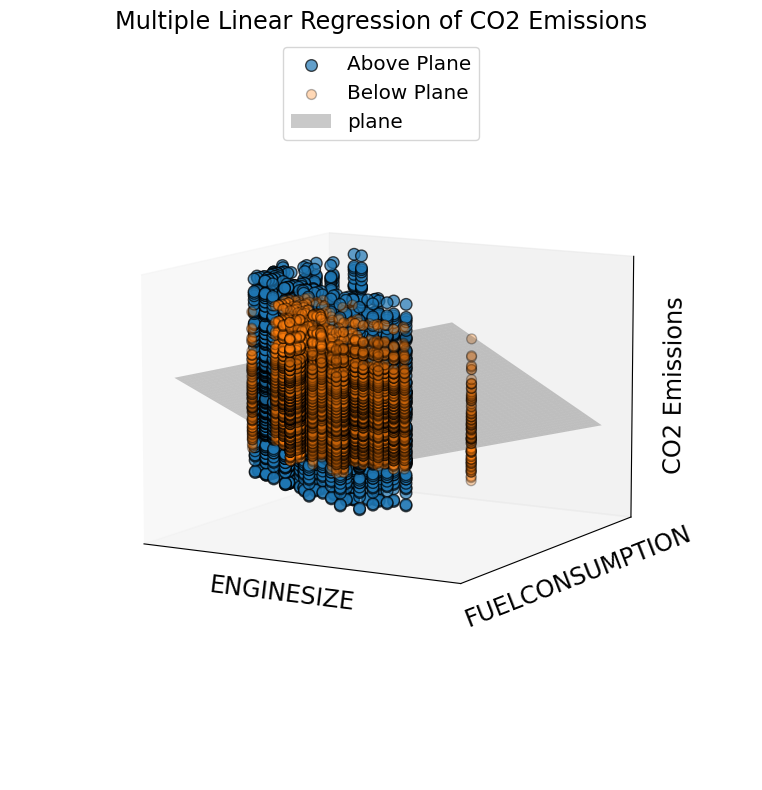

In [14]:
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)

# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100), 
                               np.linspace(X2.min(), X2.max(), 100))

y_surf = intercept_ +  coef_[0,0] * x1_surf  +  coef_[0,1] * x2_surf

# Predict y values using trained regression model to compare with actual y_test for above/below plane colors
y_pred = regressor.predict(X_test.reshape(-1, 1)) if X_test.ndim == 1 else regressor.predict(X_test)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred
above_plane = above_plane[:,0]
below_plane = below_plane[:,0]

# Plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane],  label="Above Plane",s=70,alpha=.7,ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane],  label="Below Plane",s=50,alpha=.3,ec='k')

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21,label='plane')

# Set view and labels
ax.view_init(elev=10)

ax.legend(fontsize='x-large',loc='upper center')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel('ENGINESIZE', fontsize='xx-large')
ax.set_ylabel('FUELCONSUMPTION', fontsize='xx-large')
ax.set_zlabel('CO2 Emissions', fontsize='xx-large')
ax.set_title('Multiple Linear Regression of CO2 Emissions', fontsize='xx-large')
plt.tight_layout()
plt.show()


Instead of making a 3D plot, which is difficult to interpret, you can look at vertical slices of the 3D plot by plotting each variable separately as a best-fit line using the corresponding regression parameters.


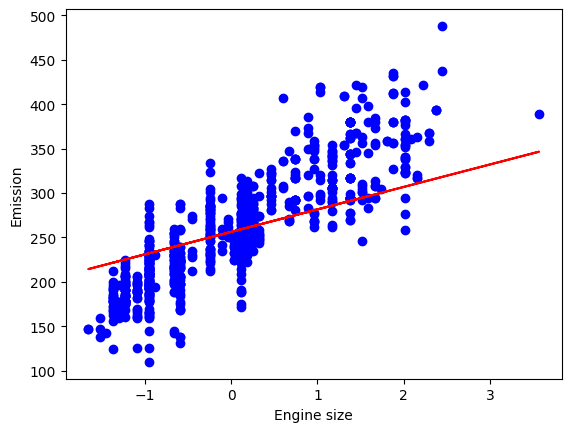

In [15]:
plt.scatter(X_train[:,0], y_train,  color='blue')
plt.plot(X_train[:,0], coef_[0,0] * X_train[:,0] + intercept_[0], '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

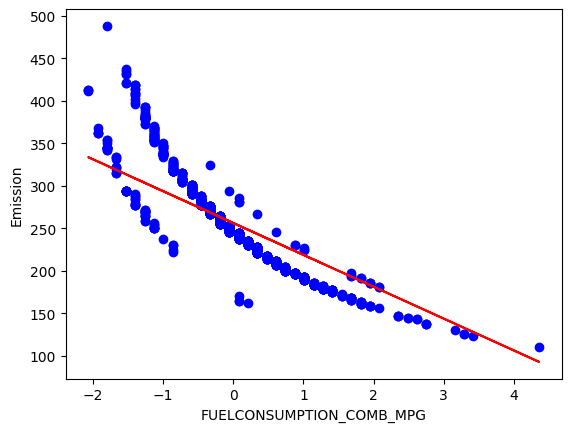

In [16]:
plt.scatter(X_train[:,1], y_train,  color='blue')
plt.plot(X_train[:,1], coef_[0,1] * X_train[:,1] + intercept_[0], '-r')
plt.xlabel("FUELCONSUMPTION_COMB_MPG")
plt.ylabel("Emission")
plt.show()

Evidently, the solution is incredibly poor because the model is trying to fit a plane to a non-planar surface.


### Exercise 1
Determine and print the parameters for the best-fit linear regression line for CO2 emission with respect to engine size.


In [ ]:
X_train_1 = # ADD CODE

regressor_1 = linear_model.LinearRegression()
regressor_1.# ADD CODE
coef_1 =  # ADD CODE
intercept_1 = # ADD CODE

print ('Coefficients: ',coef_1)
print ('Intercept: ',intercept_1)


<details><summary>Click here for the solution</summary>

```python   

X_train_1 = X_train[:,0]
regressor_1 = linear_model.LinearRegression()
regressor_1.fit(X_train_1.reshape(-1, 1), y_train)
coef_1 =  regressor_1.coef_
intercept_1 = regressor_1.intercept_
print ('Coefficients: ',coef_1)
print ('Intercept: ',intercept_1)

```

</details>


### Exercise 2
Produce a scatterplot of CO2 emission against ENGINESIZE and include the best-fit regression line to the training data.  


In [ ]:
# Enter your code here
plt.scatter(# ADD CODE, y_train,  color='blue')
plt.plot(# ADD CODE, coef_1[0] * X_train_1 + intercept_1, '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")

<details><summary>Click here for the solution</summary>

```python  
plt.scatter(X_train_1, y_train,  color='blue')
plt.plot(X_train_1, coef_1[0] * X_train_1 + intercept_1, '-r')
plt.xlabel("Engine size")
plt.ylabel("Emission")

```

</details>


Evidently, this simple linear regression model provides a much better fit of CO2 emissions on the training data than the multiple regression model did. Let's see what its performance is on the test data.


### Exercise 3
Generate the same scatterplot and best-fit regression line, but now base the result on the test data set. 
Consider how the test result compares to the training result.


In [ ]:
# Enter your code here
X_test_1 =# ADD CODE[:,0]
plt.scatter(#ADD CODE, y_test,  color='blue')
plt.plot(# ADD CODE, coef_1[0] * # ADD CODE + intercept_1, '-r')
plt.xlabel("Engine size")
plt.ylabel("CO2 Emission")

<details><summary>Click here for the solution</summary>

```python  

X_test_1 = X_test[:,0]
plt.scatter(X_test_1, y_test,  color='blue')
plt.plot(X_test_1, coef_1[0] * X_test_1 + intercept_1, '-r')
plt.xlabel("Engine size")
plt.ylabel("CO2 Emission")

```

</details>


### Exercise 4
Repeat the same modeling but use FUELCONSUMPTION_COMB_MPG as the independent variable instead. Display the model coefficients including the intercept.


In [ ]:
X_train_2 = # ADD CODE

<details><summary>Click here for the solution</summary>

```python   
X_train_2 = X_train[:,1]
regressor_2 = linear_model.LinearRegression()
regressor_2.fit(X_train_2.reshape(-1, 1), y_train)
coef_2 =  regressor_2.coef_
intercept_2 = regressor_2.intercept_
print ('Coefficients: ',coef_2)
print ('Intercept: ',intercept_2)
```

</details>


### Exercise 5
Generate a scatter plot showing the results as before on the test data.
Consider  well the model fits, and what you might be able to do to improve it. We'll revisit this later in the course.


In [ ]:
# write your code here
X_test_2 = X_test[:,# ADD CODE]
plt.scatter(X_test_2, # ADD CODE,  color='blue')
plt.plot(X_test_2, # ADD CODE, '-r')
plt.xlabel("# ADD CODE")
plt.ylabel("CO2 Emission")


<details><summary>Click here for the solution</summary>

```python
X_test_2 = X_test[:,1]
plt.scatter(X_test_2, y_test,  color='blue')
plt.plot(X_test_2, coef_2[0] * X_test_2 + intercept_2, '-r')
plt.xlabel("combined Fuel Consumption (MPG)")
plt.ylabel("CO2 Emission")
```

</details>


### Congratulations! You're ready to move on to your next lesson!
## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>

### Other Contributor(s)

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" taget="_blank">Abhishek Gagneja</a>

<h3 align="center"> © IBM Corporation. All rights reserved. <h3/>

 
<!--
## Change Log
 
 
|  Date (YYYY-MM-DD) |  Version       | Changed By     | Change Description                  |
|---|---|---|---|
| 2024-10-31         | 3.0            | Jeff Grossman  | Rewrite                             |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-11-03         | 2.1            | Lakshmi        | Made changes in URL                 |
| 2020-08-27         | 2.0            | Lavanya        | Moved lab to course repo in GitLab  |
|   |   |   |   |
